## Group 25 
### Olof Sjögren, ?h
### Romain Theodet, ?h

# Question 1: Preprocessing

## a.
For now, we use all data provided, "as is", without filtering all the extra headers.


In [77]:
from sklearn import metrics
import numpy as np
import pandas as pd
import glob

# Read all files in a directory and generate the data, merging the ham and the spam
def readFilesInDir(pathHam, pathSpam):
    # Data array, list of strings
    data = []   # ["email","email","email", "spam",...]
    # Whether each element is spam or not
    isSpam = [] # [False, False, False,True, ...]
    flag = True

    for path in (pathHam, pathSpam):
        # Get all files using regex
        allFiles = glob.glob(path)

        for filename in allFiles:
            with open(filename, mode="rb") as f:
                # Some files aren't encoded in proper UTF-8, so we use a small hack to load them,
                #  which is load them in binary and decode it while skipping bad characters
                content = f.read().decode(encoding="utf-8", errors="ignore")
                data.append(content)
                isSpam.append(flag)
        
        flag = not(flag)

    # Return the data as a dataframe
    return pd.DataFrame(list(zip(data, isSpam)), columns=["message","isSpam"])

easyData = readFilesInDir("data/easy_ham/*", "data/spam/*")
hardData = readFilesInDir("data/hard_ham/*", "data/spam/*")


To prepare the datasets for the model we read the easy ham files and spam files and mixed these together. We gave each entry a label as well to be able to distinguish spam and ham. The same was done with the hard spam files and again the spam files.
We mixed them together since we want to have a dataset we can train the model on.
The result is a dataframe with the structure:

| message                   | isSpam      |
| ------------------------- | ----------- |
| "... realEmailString ..." | False       |
| "... spamEmailString ..." | True        |
 
 -
We created 2 datasets: `easyData` and `hardData` with this data structure which will be used to train the classifier.

## b.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Shuffle the data
easyData = easyData.sample(frac=1.0, random_state=0)
hardData = hardData.sample(frac=1.0, random_state=0)

# Count vectorizer, transform the string data to a case-sensitive matrix
vectorizer = CountVectorizer(analyzer="word", lowercase=False)

easyHamTrain, easyHamTest, easySpamTrain, easySpamTest = train_test_split(
    vectorizer.fit_transform(easyData["message"]),
    easyData["isSpam"], 
    test_size=0.25,
    random_state=0,
)

hardHamTrain, hardHamTest, hardSpamTrain, hardSpamTest = train_test_split(
    vectorizer.fit_transform(hardData["message"]),
    hardData["isSpam"],
    test_size=0.25,
    random_state=0,
)


We decided to use the standard train/test size of 75% / 25%.
Furthermore, we vectorized the email text, counting the words in each email. The count is case sensitive since the use of capital letters might be an indicator of spam. 

# Question 2 / 3: Bayes classifier

## a.
Training and testing sets were split in **1b**, see above.
## b.


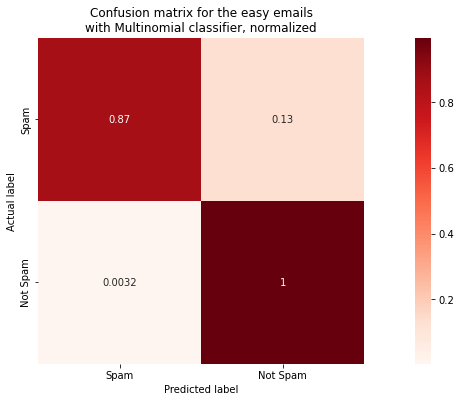

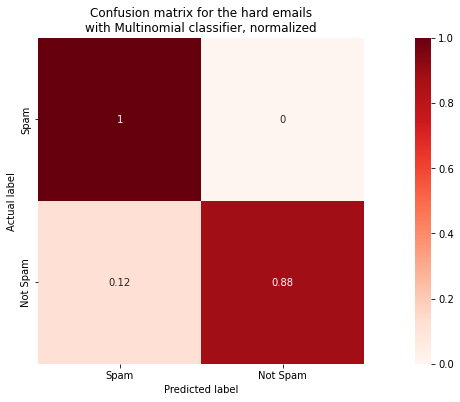

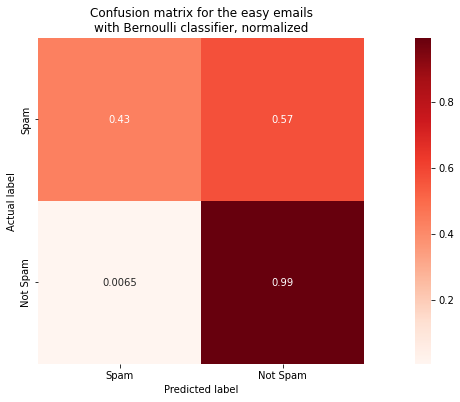

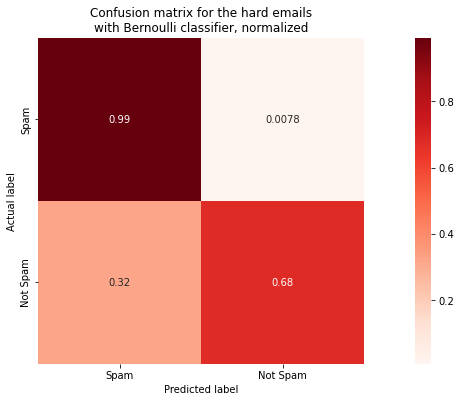

Multinomial easy email accuracy: 0.9747003994673769
Multinomial hard email accuracy: 0.9627659574468085
Bernoulli easy email accuracy:   0.8948069241011984
Bernoulli hard email accuracy:   0.8936170212765957


In [37]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Main function, will output the accuracy of a model and generate its confusion matrix 
def classify(X_train, y_train, X_test, y_test, model, title):
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Predict the results
    y_pred = model.predict(X_test)

    # Compare the predicted results to the real ones
    accuracy = metrics.accuracy_score(y_test, y_pred)

    # Generate the confusion matrix based on the predictions and the actual results
    cm = metrics.confusion_matrix(y_test, y_pred, normalize="true")

    labels = ["Spam", "Not Spam"]

    plt.figure(figsize=(18, 6))
    sns.heatmap(cm, annot=True, square=True, cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.title("Confusion matrix for the " + title + " classifier, normalized")
    plt.show()

    return accuracy

multiAccEasy = classify(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, MultinomialNB(), "easy emails\nwith Multinomial")
multiAccHard = classify(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, MultinomialNB(), "hard emails\nwith Multinomial")
bernAccEasy = classify(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, BernoulliNB(), "easy emails\nwith Bernoulli")
bernAccHard = classify(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, BernoulliNB(), "hard emails\nwith Bernoulli")

print(f"Multinomial easy email accuracy: {multiAccEasy}")
print(f"Multinomial hard email accuracy: {multiAccHard}")
print(f"Bernoulli easy email accuracy:   {bernAccEasy}")
print(f"Bernoulli hard email accuracy:   {bernAccHard}")


The Multinomial Naive Bayes classifier had great accuracy both on the easy set as well as the hard set. There is an interesting difference between the classification of the easy and hard sets. For the easy classification, the classifier is great at identifying emails which are **not** spam correctly, it doesn't make many mistakes here. However it has a harder time classifying emails which **are** spam, some of these will be classified as legit altough they are spam.
Interestingly enough for the hard classifier, the opposite is true. This classifier will be stricter and no spam will be classified as legit or "ham". But since it is stricter, emails which are not spam will be classified as spam.
There is a dilemma choosing between the classifiers, does one want some spam to make it through the filter or does one want some legit emails to be classified as spam?

The Bernoulli Naive Bayes doesn't really work, since for easy emails it has a majority of false negatives, and for the hard ones it isn't clear whether it is a true negative or a false positive. However, we found it interesting that the error "flips" between easy and hard emails, like the Multinomial classifier. With this classifier though, the flip is way more noticeable. 
Once again there is a dilemma of over- and under-classification of spam.
Note: we didn't add the `binarize` flag, since it led to worse accuracy score.

Overall, it seems pretty clear that the Multinomial classifier is better than the Bernoulli one, as the ratio of false positive and false negative is several times lower.

# Question 4: Words filtering

## a.

Filtering out common words might be useful to prevent bloating the matrix with useless information, or worse, classify uncommon words as noise. We don't want common/filler words to make up most of the data training the model since there is a higher chance they overlap and in a spam email and a legit email. Filtering out these words also makes the model train faster as it does not have to take these filler words into account which carry no value in the distinction between a spam and a legit email.

For example, common words like `the` or `a` will probably have the same repartition in both messages,
as they are simply building blocks of the english language.
However, words related to winning, diseases or sexual practices will probably be way more frequent in spam emails, and shouldn't be treated as background noise.

We can find some of the common words in the data set by looking at the vectorized words.


In [73]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_features=25)
matrix = vectorizer.fit_transform(easyData["message"])

counts = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out()).sum()
counts.sort_values(axis=0, ascending=False, inplace=True)

print(f"The most common words are: \n\n {counts}")


The most common words are: 

 com             31077
the             26108
org             25475
2002            25369
net             20368
from            19262
with            19239
for             18928
to              18628
by              18585
localhost       18042
Received        16320
spamassassin    15520
of              15101
and             14047
11              13488
taint           12254
Sep             11917
id              11836
3D              11377
To              11366
xent            11234
fork            11018
http            10355
List            10129
dtype: int64


Using `CountVectorizer` to find the 25 most frequent words we do indeed find common words such as `the`, `and`, `to`, `of` as we predicted. We also see odd words such as `com`, probably extracted from the email adress in the meta data, and `2002` also probably from the meta data since the emails seems to be sent during the year 2002.


## b.

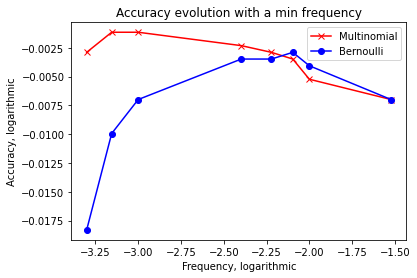

In [91]:
import math

# Calculate different accuracies
accuraciesM = []
accuraciesB = []
freqs = (0.0005, 0.0007, 0.001, 0.004, 0.006, 0.008, 0.01, 0.03)

for freq in freqs:
    vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_df=0.75, min_df=freq)

    xTrain, xTest, yTrain, yTest = train_test_split(
        vectorizer.fit_transform(easyData["message"]),
        easyData["isSpam"], 
        test_size=0.25,
        random_state=0,
    )

    modelM = MultinomialNB()
    modelM.fit(xTrain, yTrain)

    modelB = BernoulliNB()
    modelB.fit(xTrain, yTrain)

    yPred = modelB.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesB.append(math.log(accuracy, 10))

    yPred = modelM.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesM.append(math.log(accuracy, 10))

# Plotting the graph
plt.plot([math.log(f, 10) for f in freqs], accuraciesM, c="red", marker="x", label="Multinomial")
plt.plot([math.log(f, 10) for f in freqs], accuraciesB, c="blue", marker="o", label="Bernoulli")
plt.xlabel("Frequency, logarithmic")
plt.ylabel("Accuracy, logarithmic")
plt.title("Accuracy evolution with a min frequency")
plt.legend()
plt.show()


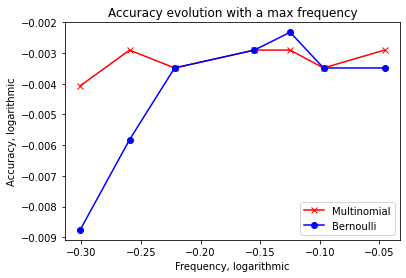

In [89]:
accuraciesM = []
accuraciesB = []
freqs = (0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.9)

for freq in freqs:
    vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_df=freq, min_df=0.005)

    xTrain, xTest, yTrain, yTest = train_test_split(
        vectorizer.fit_transform(easyData["message"]),
        easyData["isSpam"], 
        test_size=0.25,
        random_state=0,
    )

    modelM = MultinomialNB()
    modelM.fit(xTrain, yTrain)

    modelB = BernoulliNB()
    modelB.fit(xTrain, yTrain)

    yPred = modelB.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesB.append(math.log(accuracy, 10))

    yPred = modelM.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesM.append(math.log(accuracy, 10))

# Plotting the elbow method graph
plt.plot([math.log(f, 10) for f in freqs], accuraciesM, c="red", marker="x", label="Multinomial")
plt.plot([math.log(f, 10) for f in freqs], accuraciesB, c="blue", marker="o", label="Bernoulli")
plt.xlabel("Frequency, logarithmic")
plt.ylabel("Accuracy, logarithmic")
plt.title("Accuracy evolution with a max frequency")
plt.legend()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ab83f1d1-4f39-4251-b899-1ad25d544179' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>